## Setup

In [1]:
pip install scikeras

In [2]:
import json
import re
import nltk
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/My Drive/News_Category_Dataset_v3.json'

df = pd.read_json(file_path, lines=True)

## Data Clean Up and Processing

In [5]:
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

In [6]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text).lower())

    tokens = word_tokenize(text)

    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]

    cleaned_text = ' '.join(tokens)

    return cleaned_text

df['cleaned_headline'] = df['headline'].apply(preprocess_text)
df['cleaned_short_description'] = df['short_description'].apply(preprocess_text)

In [7]:
## check results
print(df[['cleaned_headline', 'cleaned_short_description', 'category']])

                                         cleaned_headline  \
0       4 million american roll sleev omicrontarget co...   
1       american airlin flyer charg ban life punch fli...   
2                23 funniest tweet cat dog week sept 1723   
3                    funniest tweet parent week sept 1723   
4       woman call cop black birdwatch lose lawsuit ex...   
...                                                   ...   
209522     rim ceo thorsten hein signific plan blackberri   
209523  maria sharapova stun victoria azarenka austral...   
209524  giant patriot jet colt among improb super bowl...   
209525          aldon smith arrest 49er lineback bust dui   
209526        dwight howard rip teammat magic loss hornet   

                                cleaned_short_description   category  
0       health expert said earli predict whether deman...  U.S. NEWS  
1       subdu passeng crew fled back aircraft confront...  U.S. NEWS  
2                         dog dont understand could ea

## Exploratory Data Analysis (EDA)

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

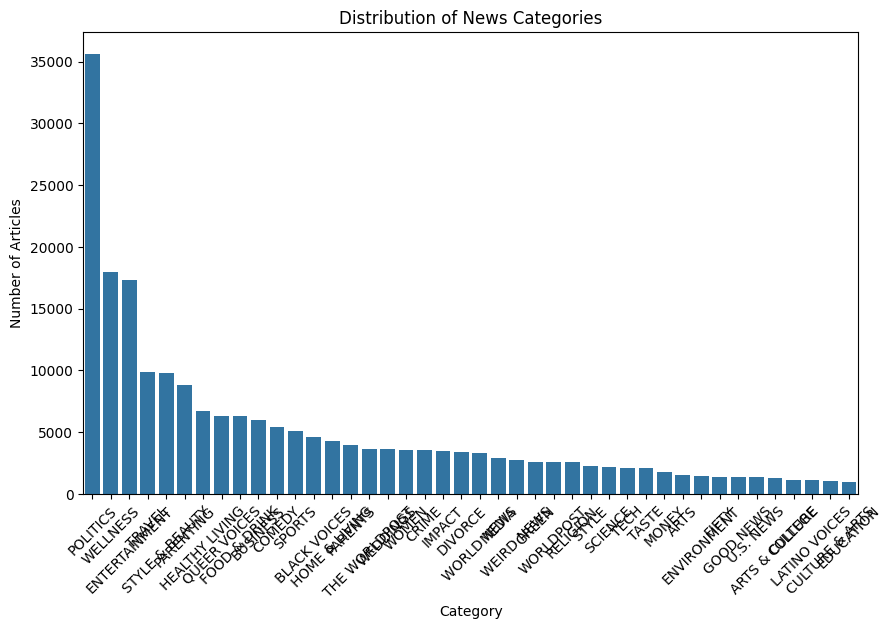

In [9]:
## examine distribution of news categories to see potential impact on model; helps analyze if any classes are imbalanced

category_counts = df['category'].value_counts()

plt.figure(figsize=(10, 6))
sns.barplot(x=category_counts.index, y=category_counts.values)
plt.xlabel('Category')
plt.ylabel('Number of Articles')
plt.title('Distribution of News Categories')
plt.xticks(rotation=45)
plt.show()

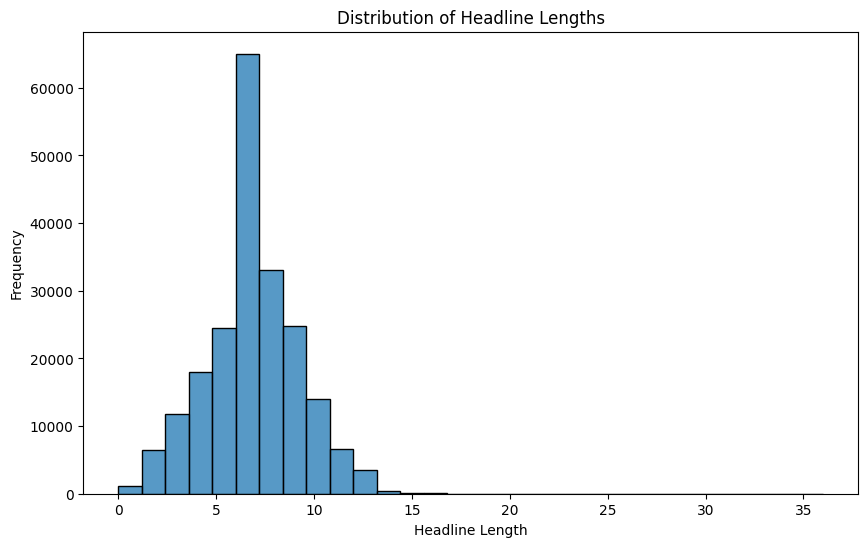

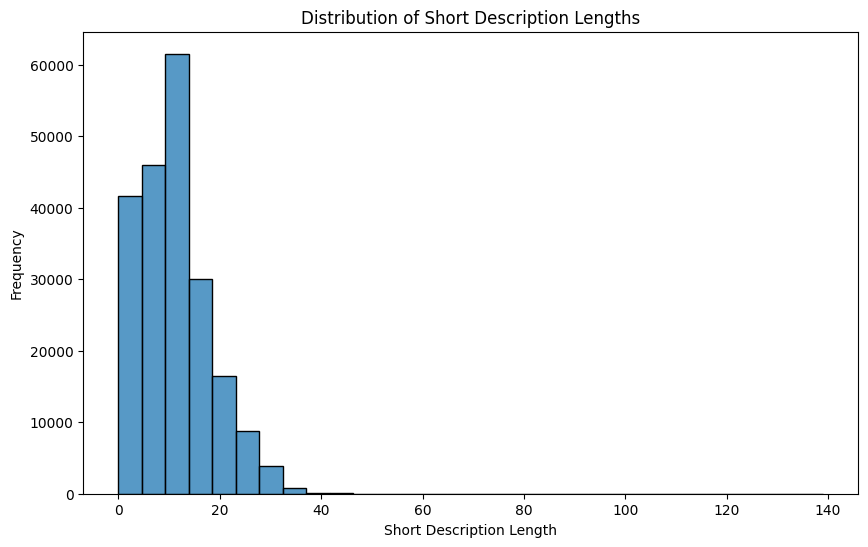

In [10]:
## look at the length of headlines and short descriptions; helps determine if we should remove text

df['headline_length'] = df['cleaned_headline'].apply(lambda x: len(x.split()))
df['description_length'] = df['cleaned_short_description'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['headline_length'], bins=30)
plt.xlabel('Headline Length')
plt.ylabel('Frequency')
plt.title('Distribution of Headline Lengths')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['description_length'], bins=30)
plt.xlabel('Short Description Length')
plt.ylabel('Frequency')
plt.title('Distribution of Short Description Lengths')
plt.show()

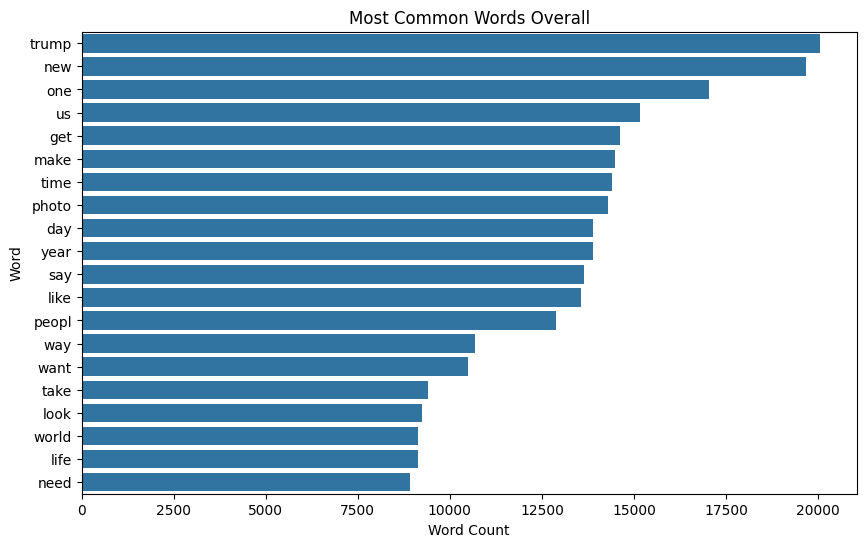

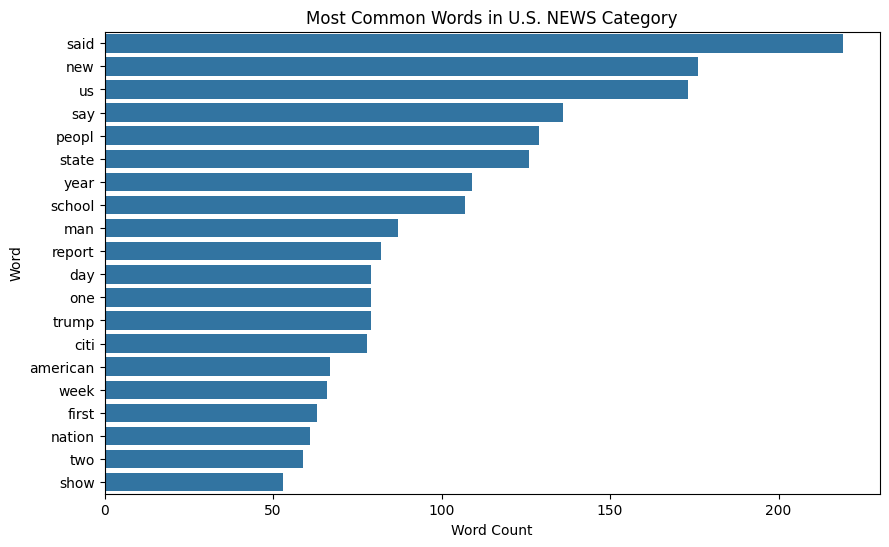

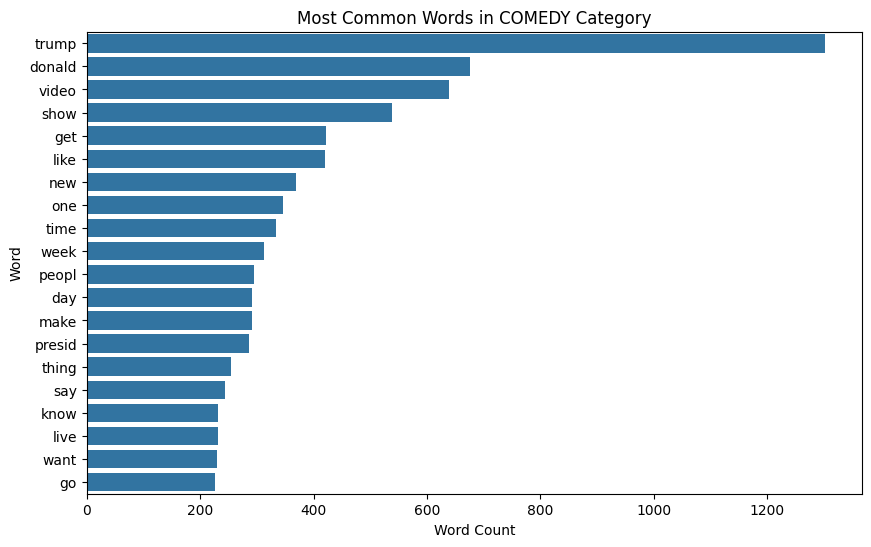

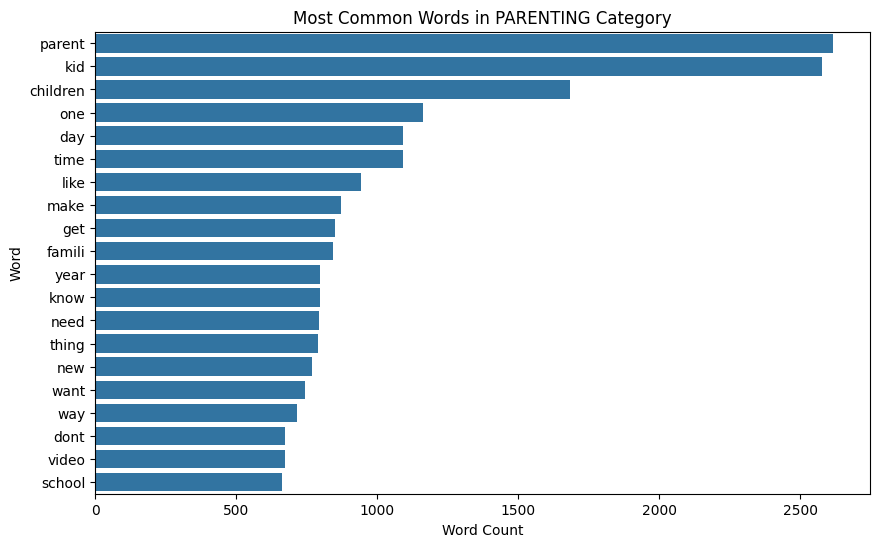

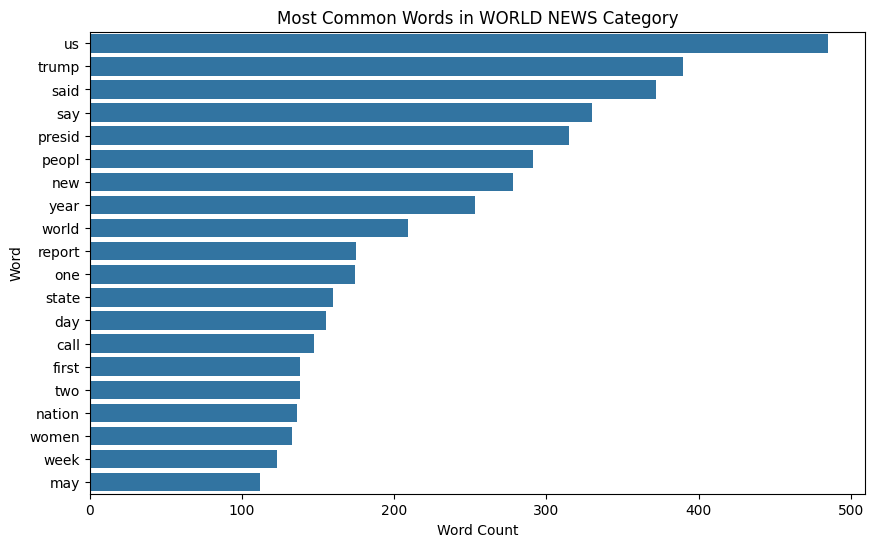

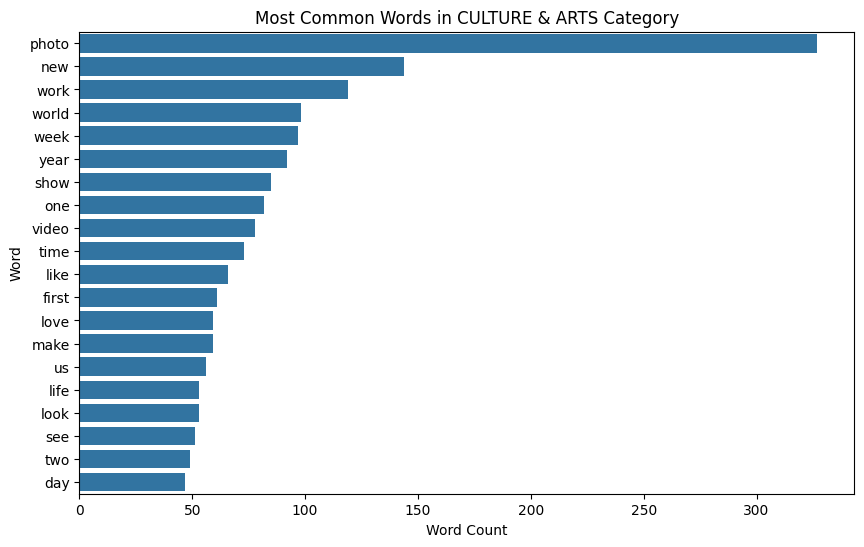

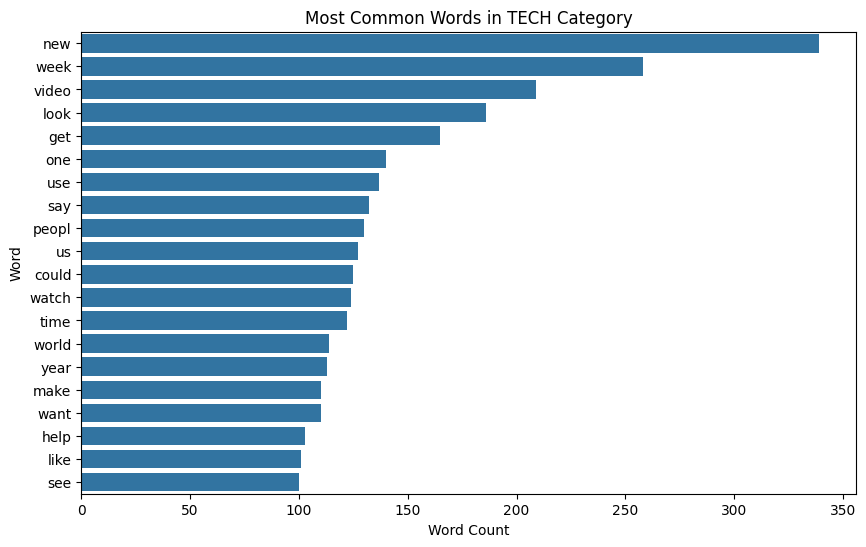

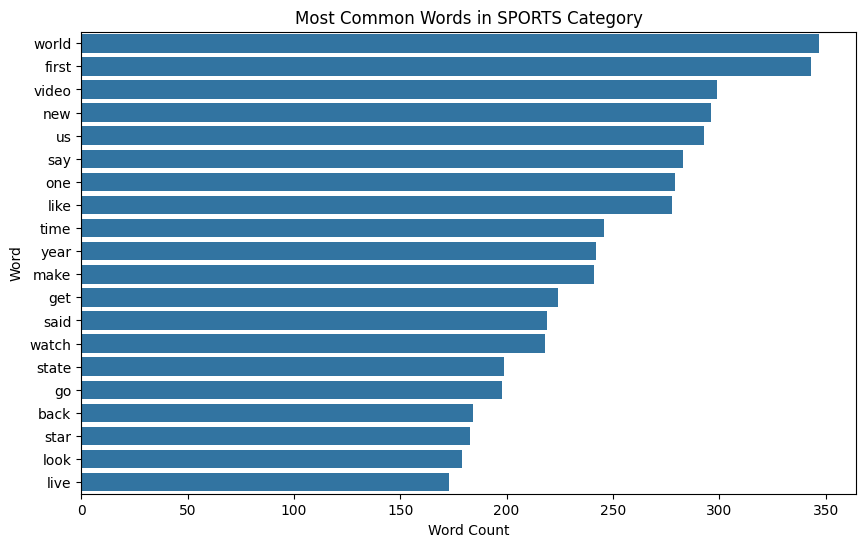

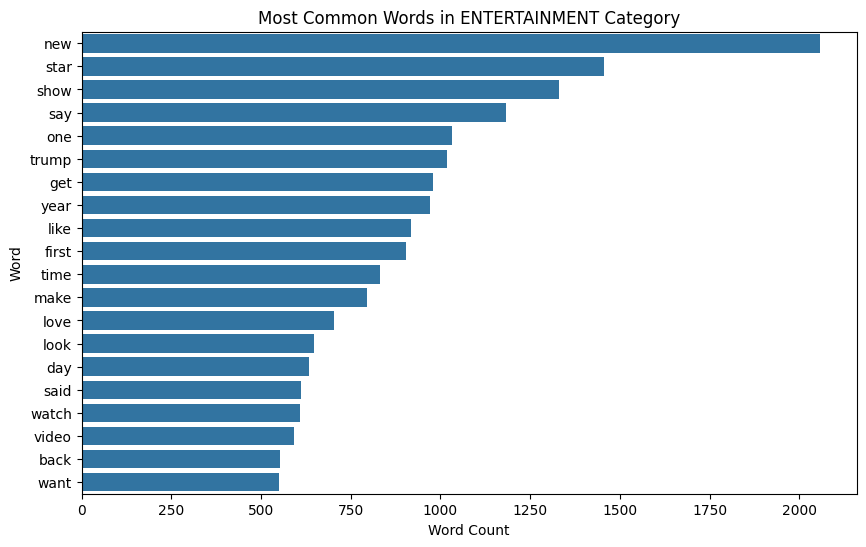

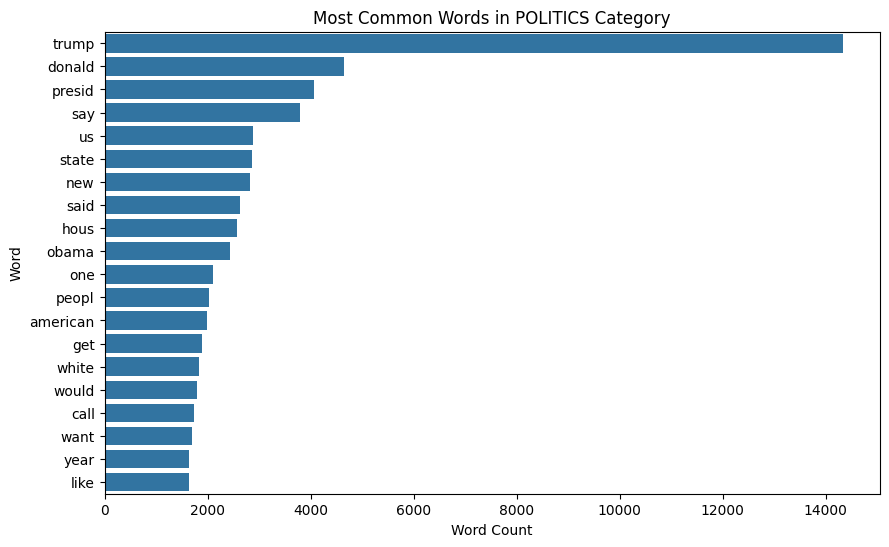

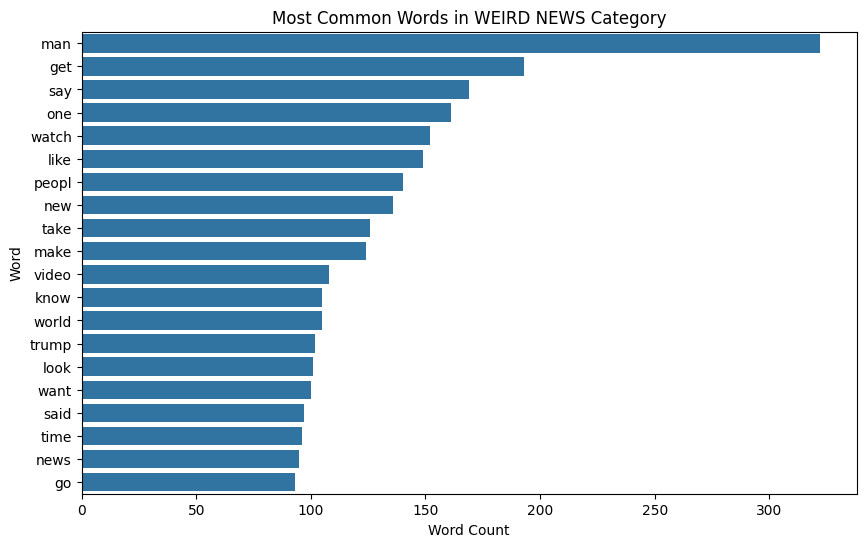

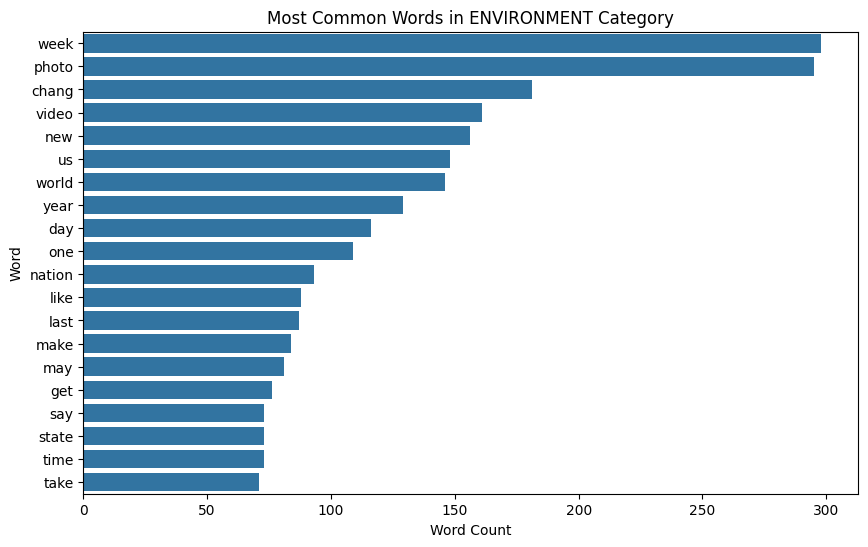

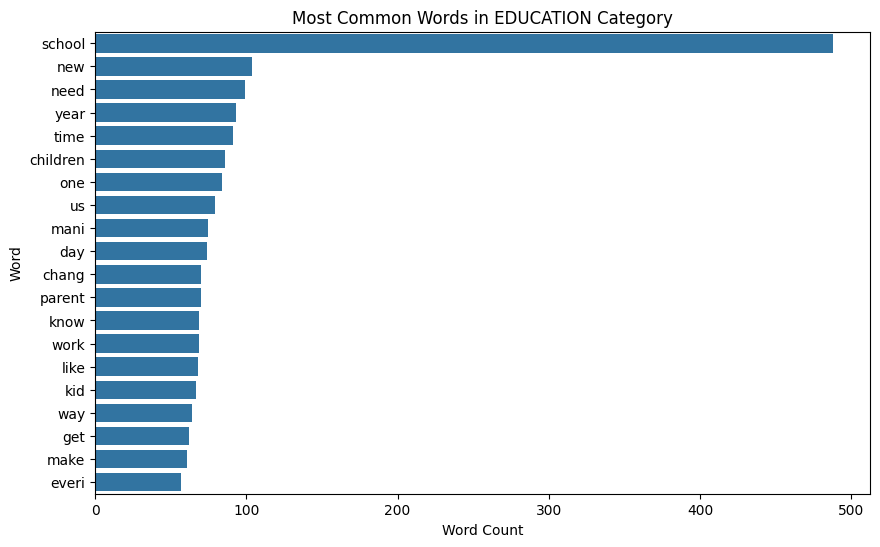

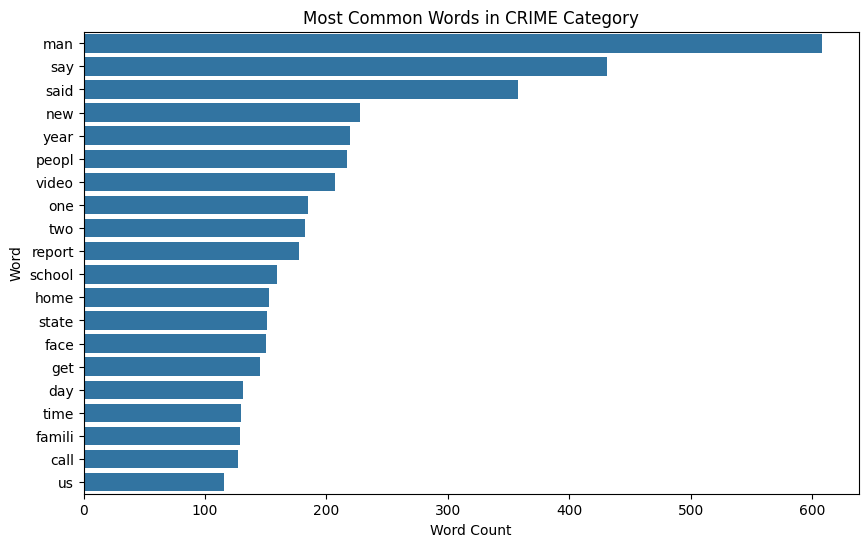

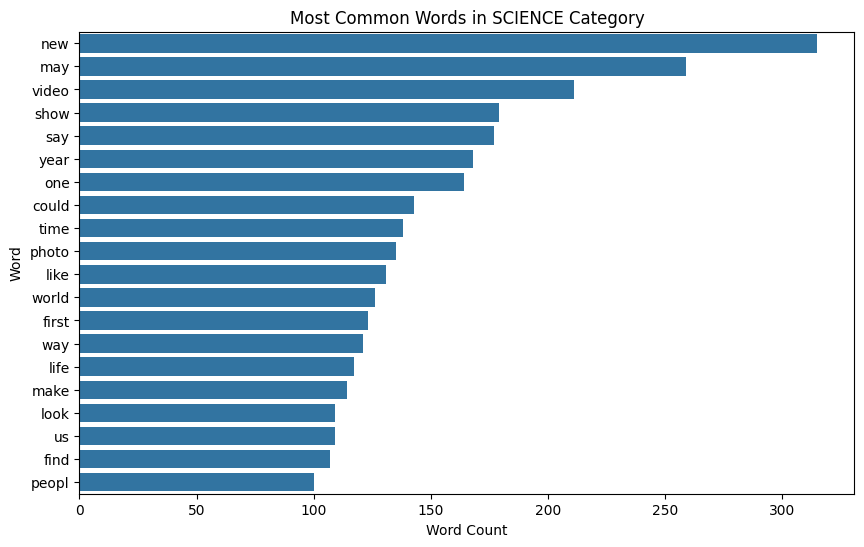

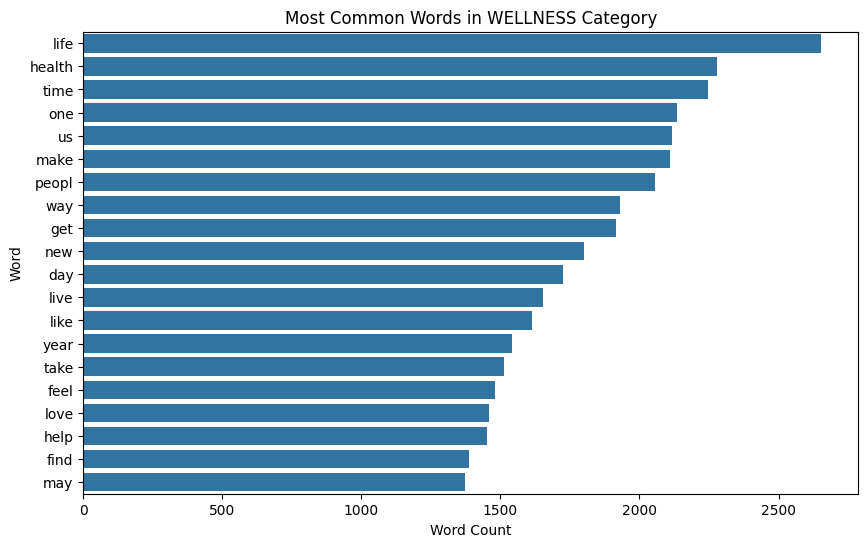

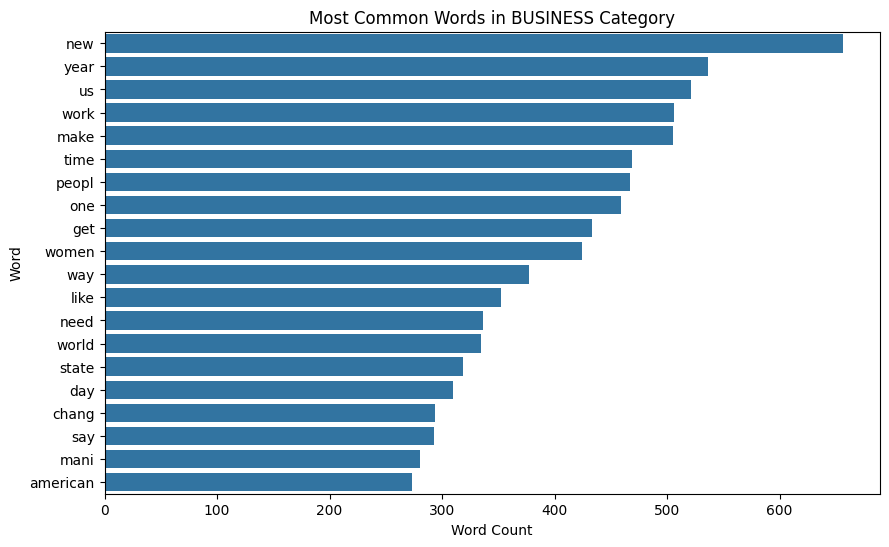

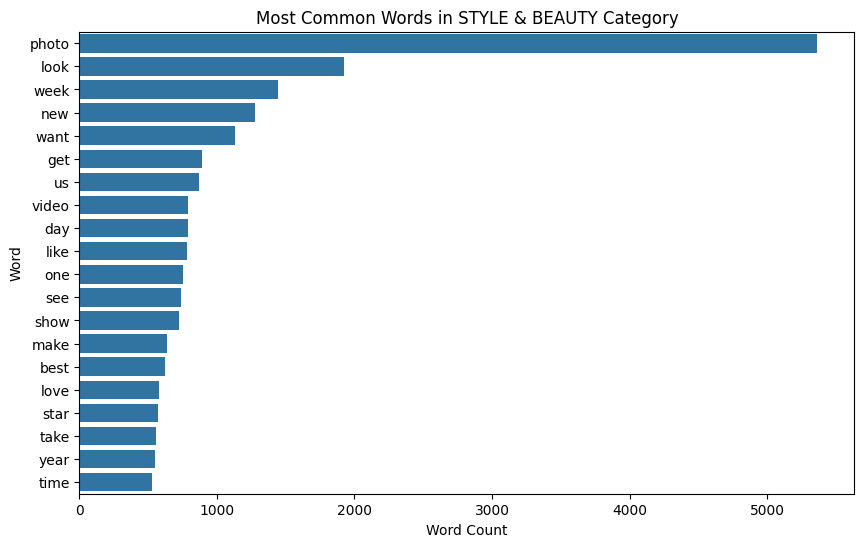

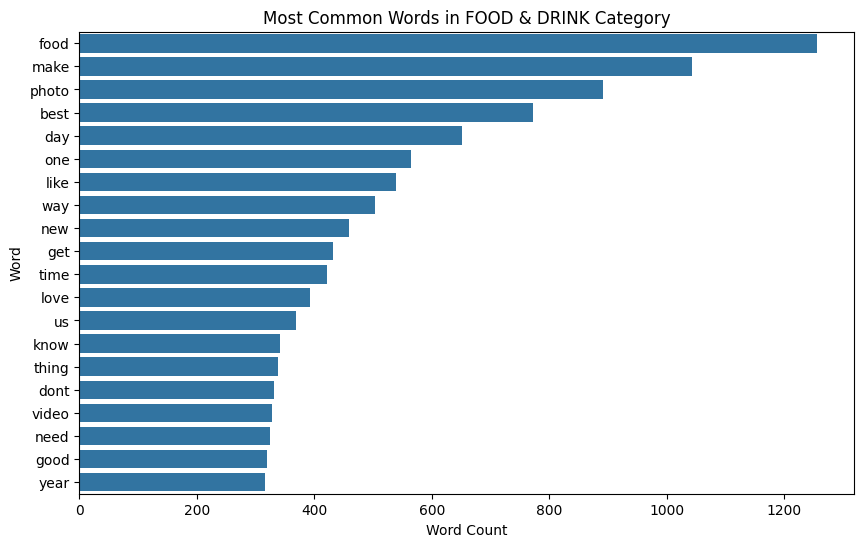

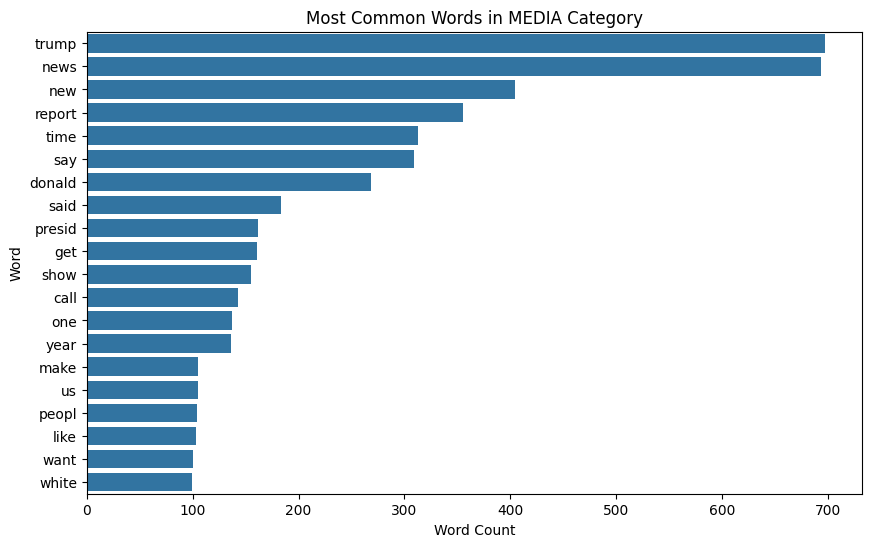

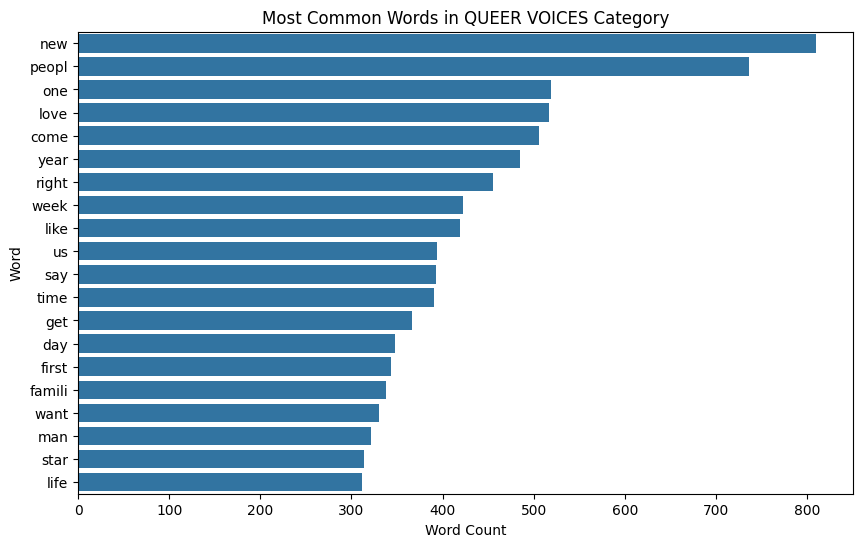

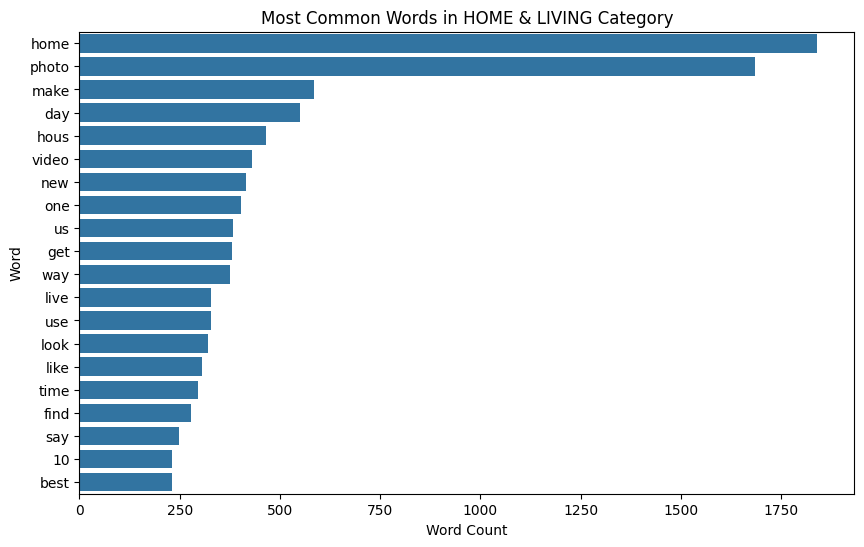

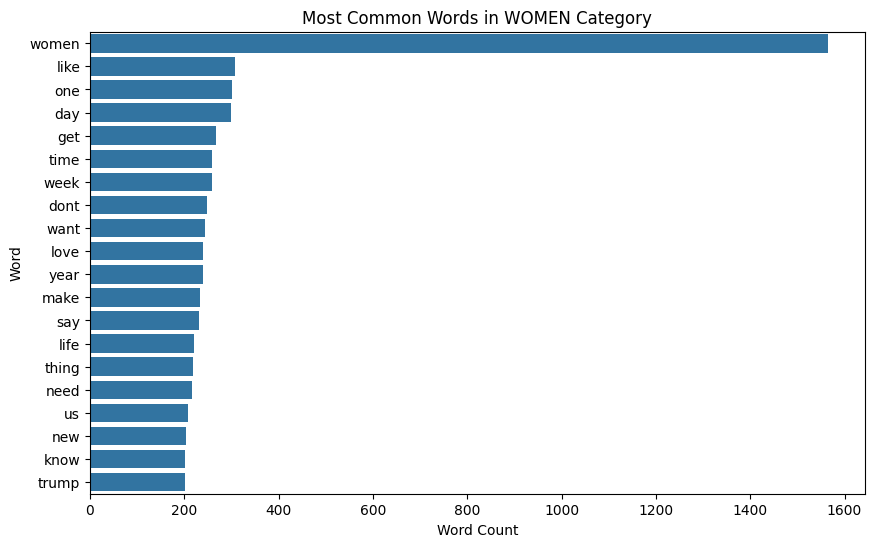

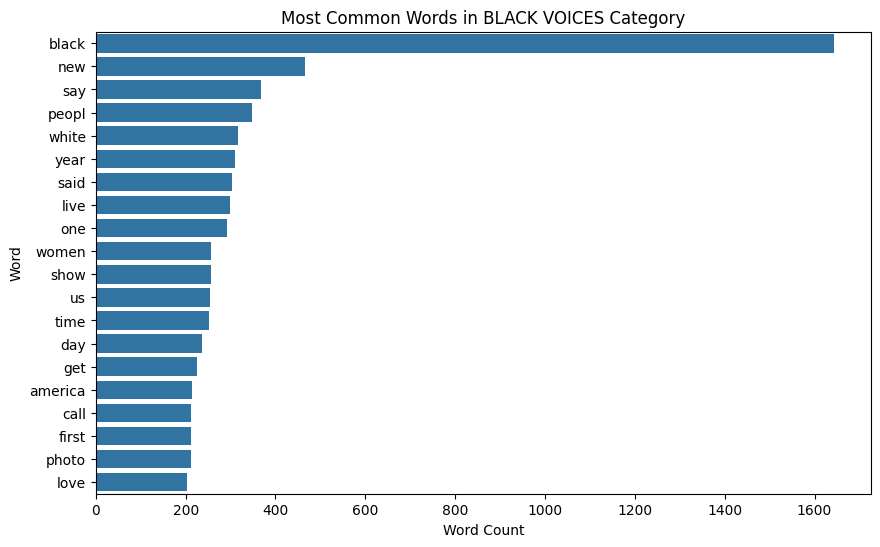

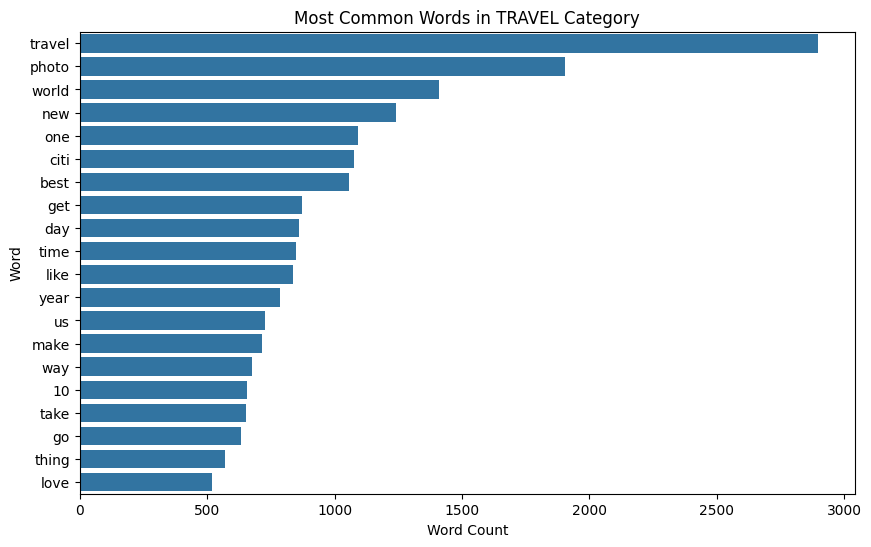

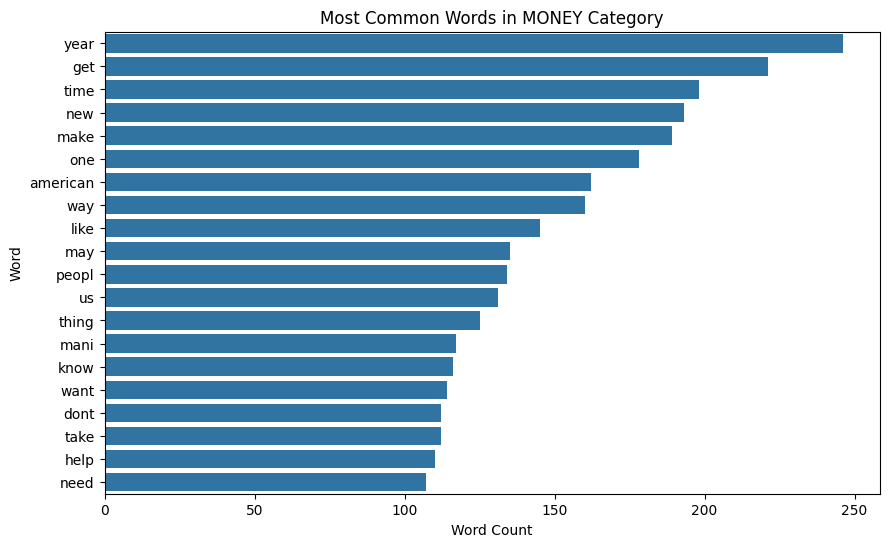

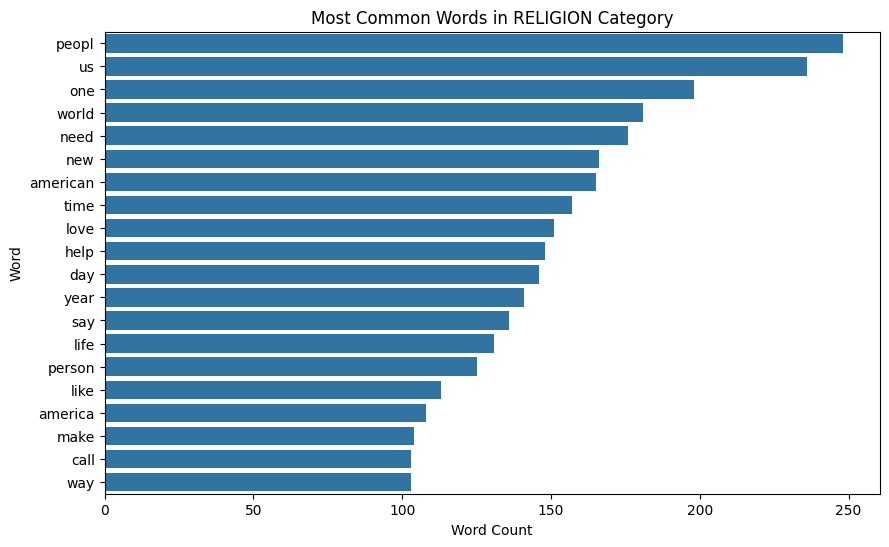

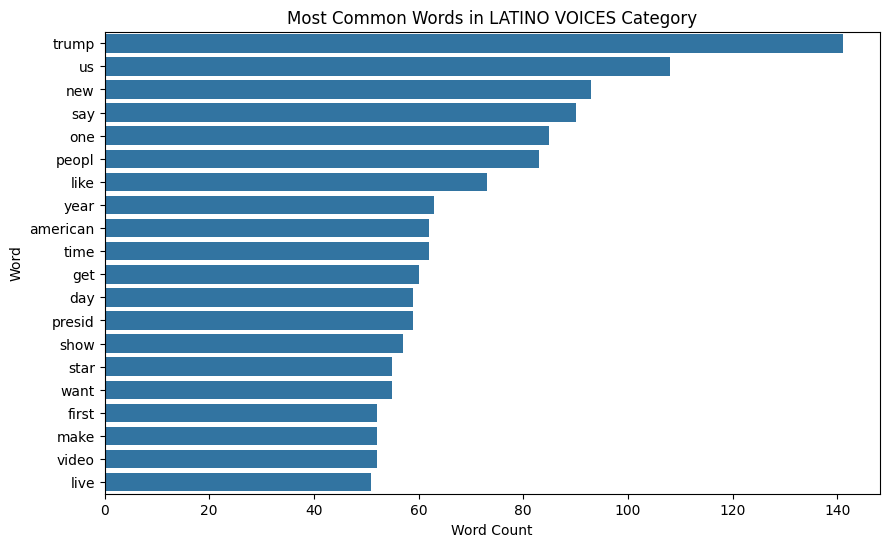

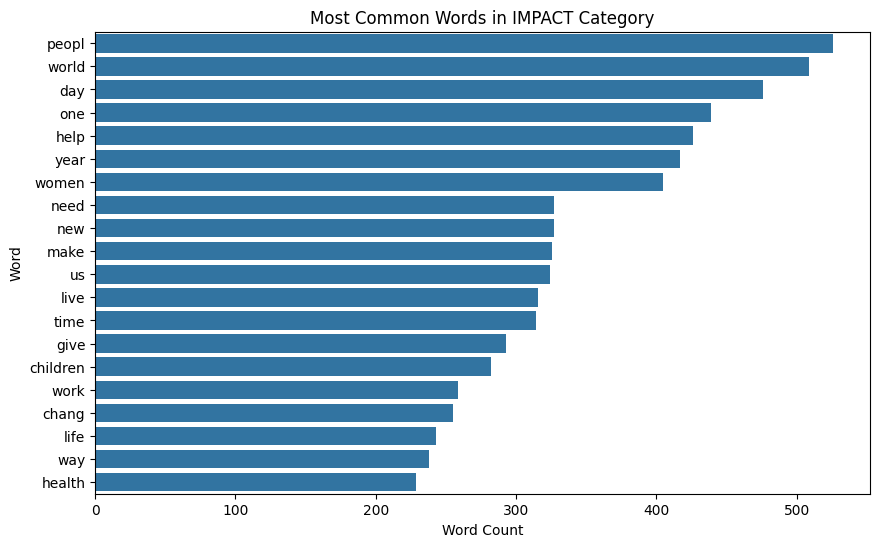

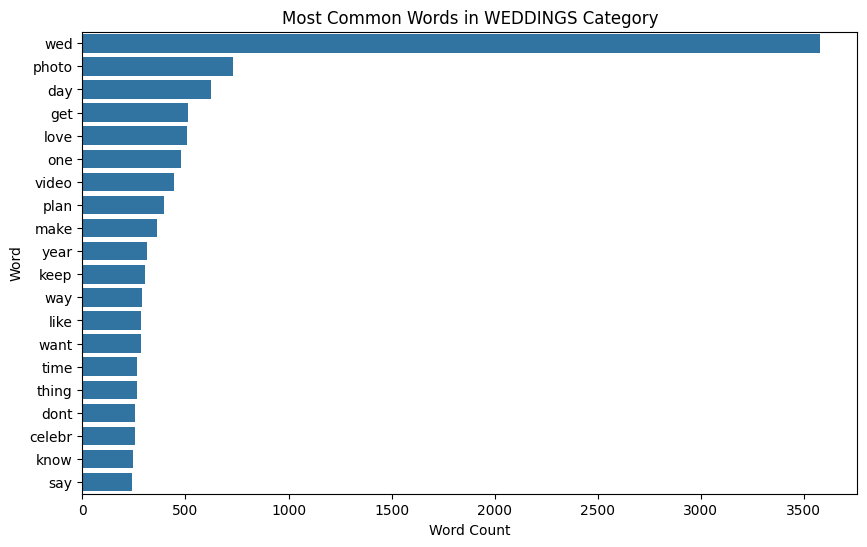

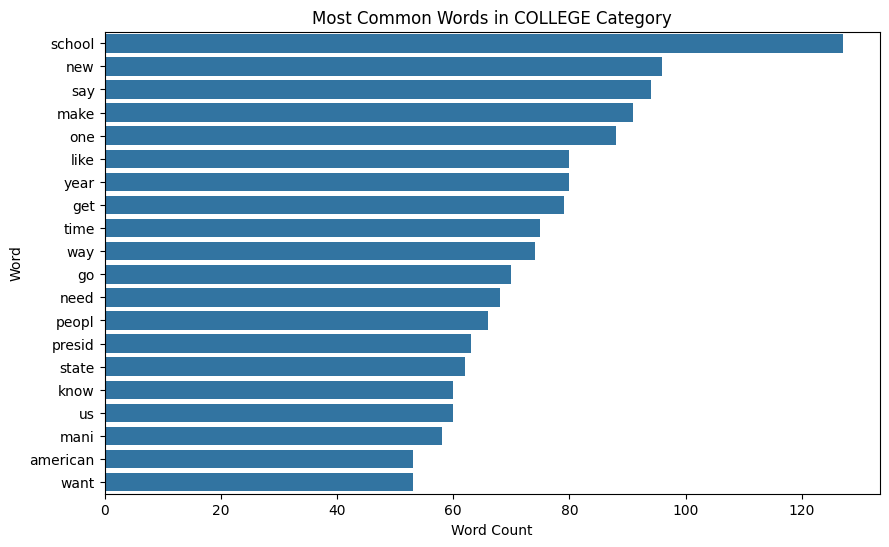

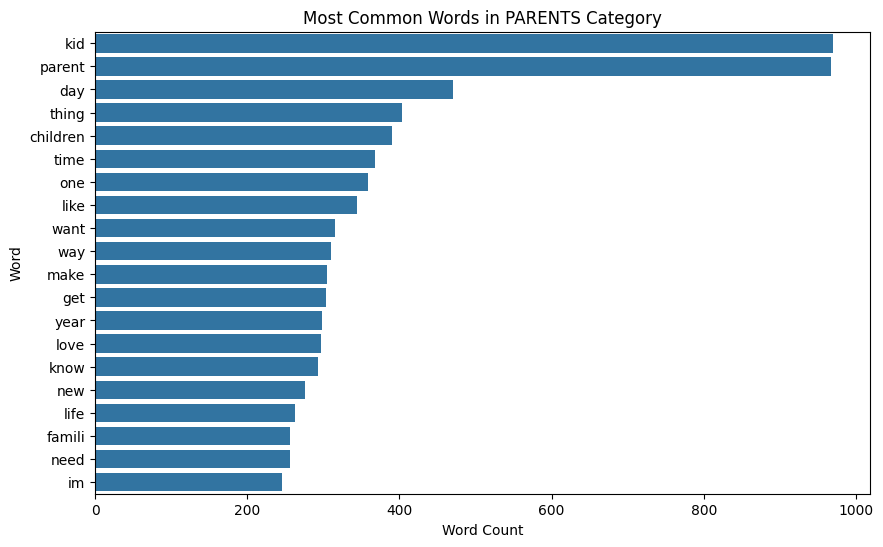

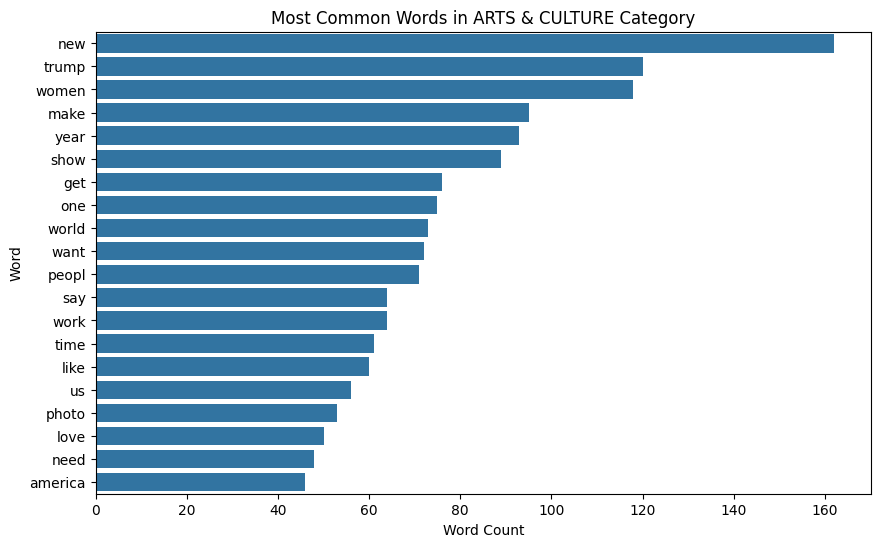

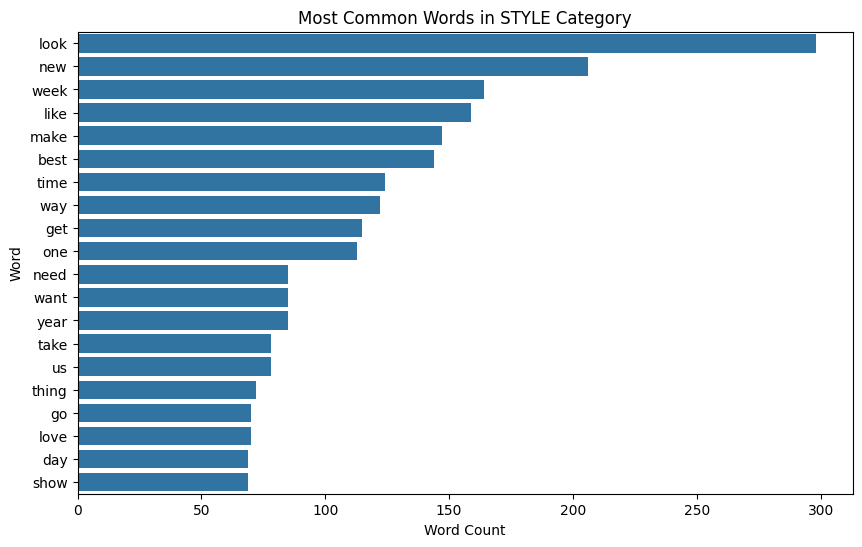

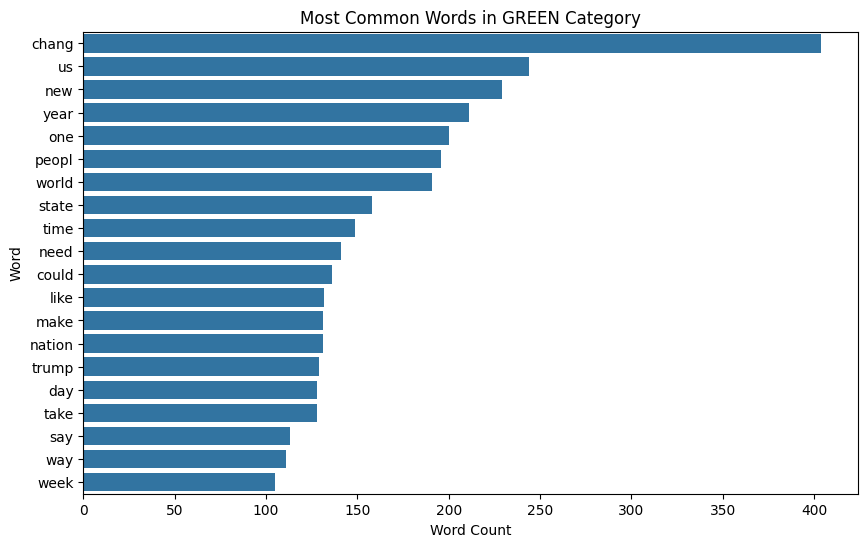

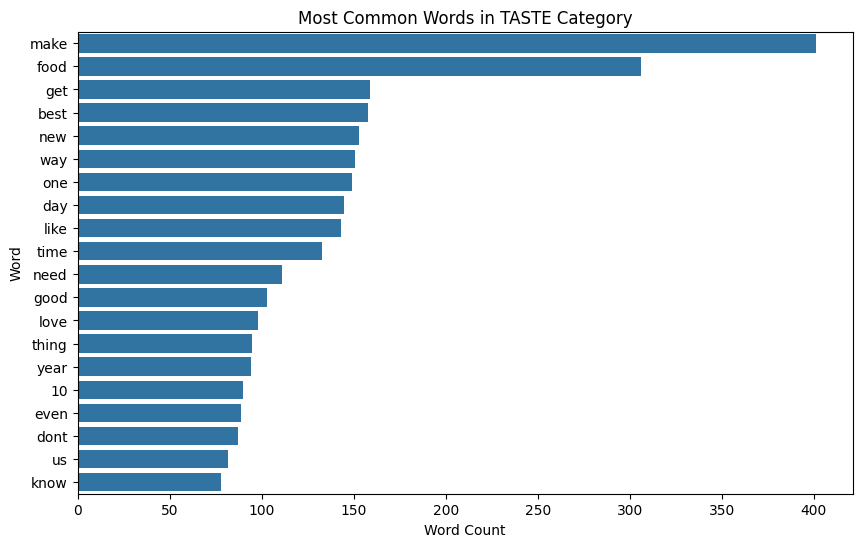

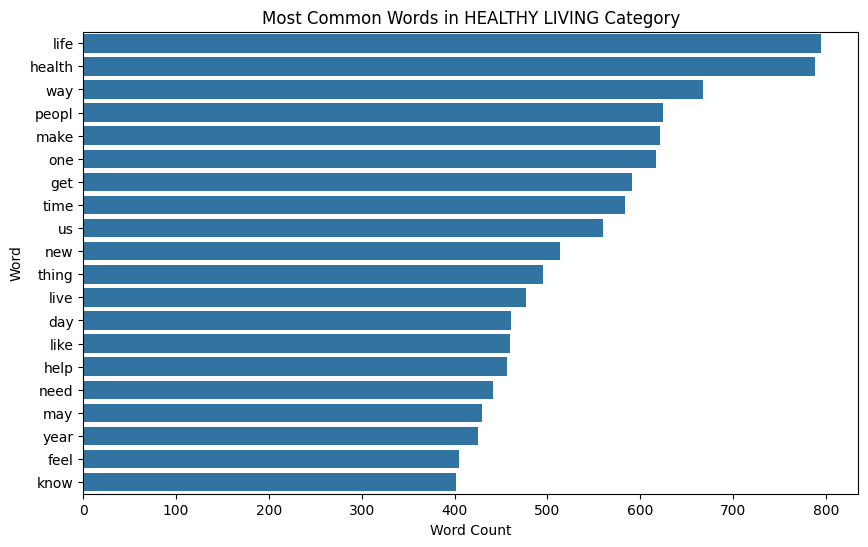

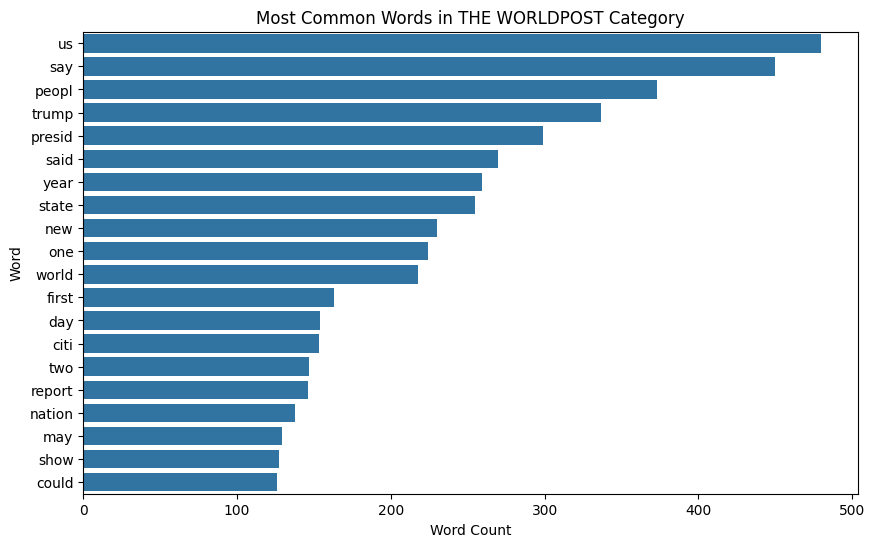

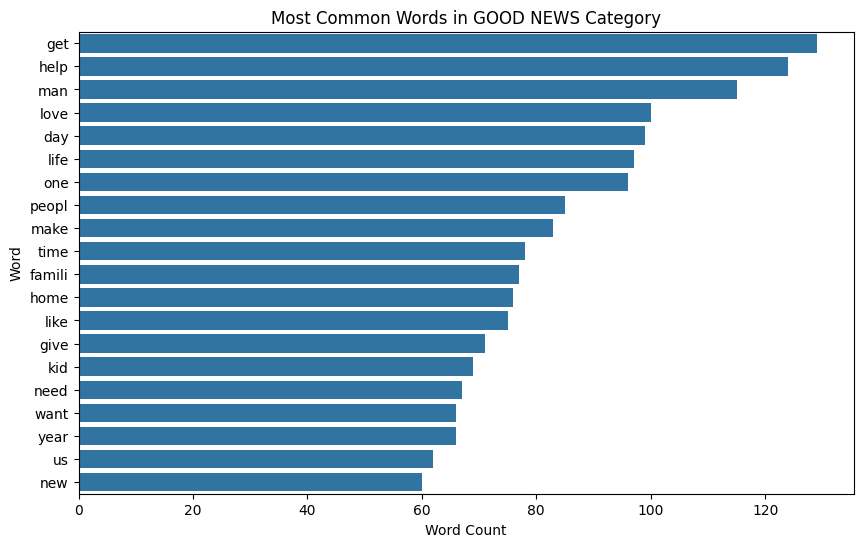

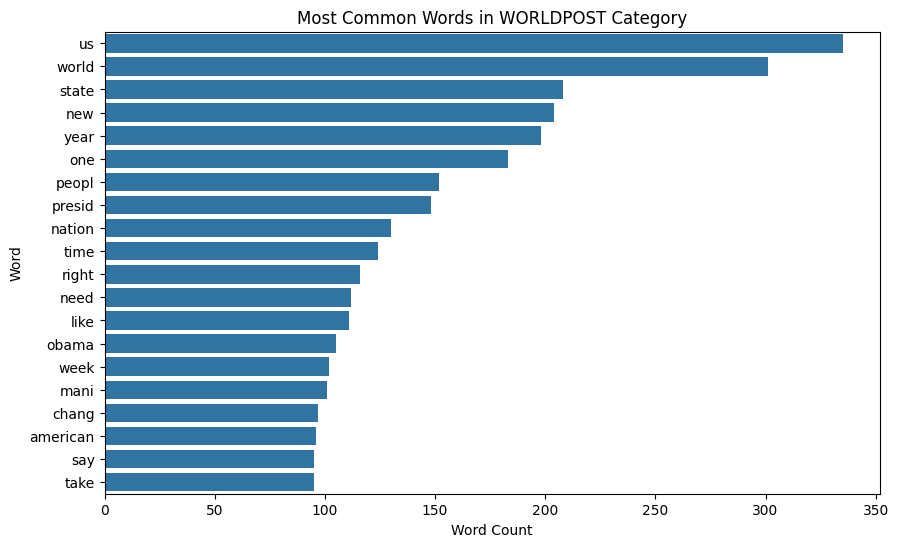

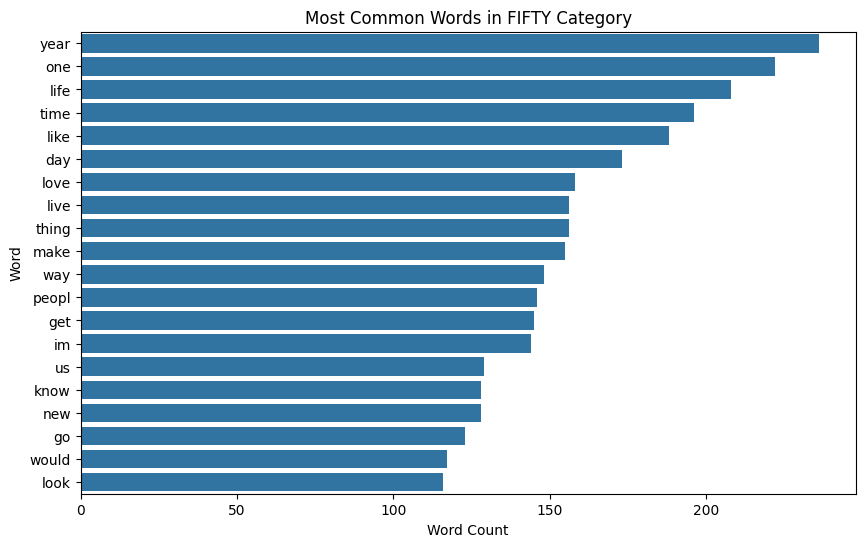

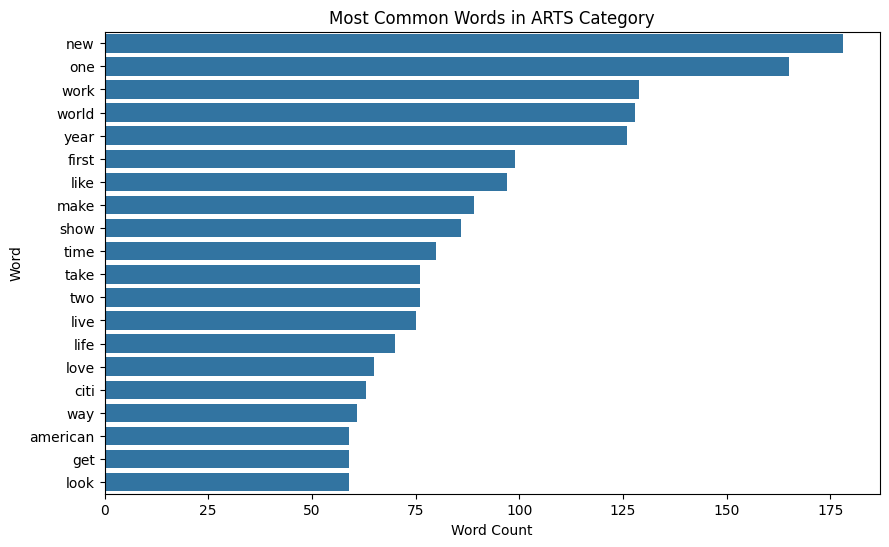

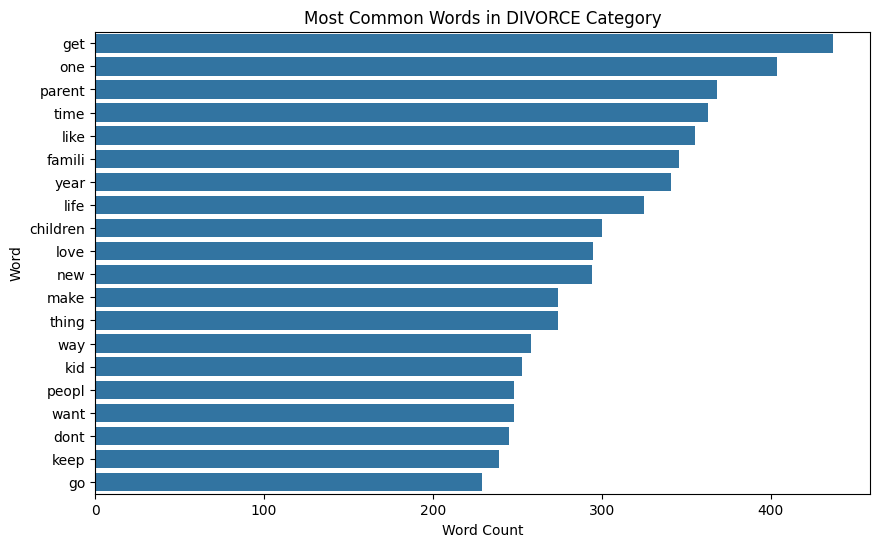

In [11]:
## examine the influence of different keywords on different categories; helps to understand how to distinguish features

from sklearn.feature_extraction.text import CountVectorizer

df['combined_text'] = df['cleaned_headline'] + ' ' + df['cleaned_short_description']

vectorizer = CountVectorizer(max_features=100)

word_counts = vectorizer.fit_transform(df['combined_text'])

vocab = vectorizer.get_feature_names_out()
word_counts = word_counts.sum(axis=0).A1

word_freq_df = pd.DataFrame({'word': vocab, 'count': word_counts})

plt.figure(figsize=(10, 6))
sns.barplot(x='count', y='word', data=word_freq_df.nlargest(20, 'count'))
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.title('Most Common Words Overall')
plt.show()

for category in df['category'].unique():
    category_df = df[df['category'] == category]
    category_word_counts = vectorizer.transform(category_df['combined_text'])
    category_word_counts = category_word_counts.sum(axis=0).A1
    category_word_freq_df = pd.DataFrame({'word': vocab, 'count': category_word_counts})

    plt.figure(figsize=(10, 6))
    sns.barplot(x='count', y='word', data=category_word_freq_df.nlargest(20, 'count'))
    plt.xlabel('Word Count')
    plt.ylabel('Word')
    plt.title(f'Most Common Words in {category} Category')
    plt.show()

## Feature Engineering and Transformations

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [13]:
## limit features to top 5000 words

tfidf_vectorizer = TfidfVectorizer(max_features=5000)

tfidf_matrix = tfidf_vectorizer.fit_transform(df['combined_text'])

feature_names = tfidf_vectorizer.get_feature_names_out()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

In [14]:
## convert categorical labels to numerics

label_encoder = LabelEncoder()

encoded_labels = label_encoder.fit_transform(df['category'])

In [15]:
## combine the encoded labels with the TF-IDF features

features_df = pd.concat([tfidf_df, pd.DataFrame({'category': encoded_labels})], axis=1)

In [16]:
# split data into training and test

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_df.drop('category', axis=1),
                                                    features_df['category'],
                                                    test_size=0.2,
                                                    random_state=42)

## Modeling

In [17]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


In [18]:
## define the different models we'll be testing

models = [
    ('Multinomial Naive Bayes', MultinomialNB()),
    ('Logistic Regression', LogisticRegression()),
    ('Random Forest', RandomForestClassifier()),
    ('Linear SVC', LinearSVC()),
]

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.utils import resample

cv_folds = 5

cv_subset_size = 0.2

cv_subset_indices = resample(range(len(X_train)), n_samples=int(len(X_train) * cv_subset_size), random_state=42)
X_train_subset = X_train.iloc[cv_subset_indices]
y_train_subset = y_train.iloc[cv_subset_indices]

cv_scores = []
for name, model in models:
    scores = cross_val_score(model, X_train_subset, y_train_subset, cv=cv_folds, scoring='accuracy', n_jobs=-1)
    cv_scores.append((name, scores.mean(), scores.std()))

for name, mean_score, std_score in cv_scores:
    print(f"{name}: Mean Accuracy = {mean_score:.3f}, Std Deviation = {std_score:.3f}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Multinomial Naive Bayes: Mean Accuracy = 0.441, Std Deviation = 0.004
Logistic Regression: Mean Accuracy = 0.544, Std Deviation = 0.005
Random Forest: Mean Accuracy = 0.563, Std Deviation = 0.006
Linear SVC: Mean Accuracy = 0.576, Std Deviation = 0.007


In [20]:
## find the best performing model, train, and evaluate against test set

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

best_model = models[np.argmax([score[1] for score in cv_scores])][1]

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nBest Model: {type(best_model).__name__}")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(



Best Model: LinearSVC
Accuracy: 0.587
Precision: 0.564
Recall: 0.587
F1 Score: 0.567


## Deep Learning - CNN

In [20]:
# Tokenize and pad sequences
max_words = 10000
max_length = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['combined_text'])
sequences = tokenizer.texts_to_sequences(df['combined_text'])
X = pad_sequences(sequences, maxlen=max_length)

label_map = {label: index for index, label in enumerate(df['category'].unique())}
y = df['category'].map(label_map).values

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

def create_model(embedding_dim=128, conv_filters=64, conv_kernel_size=5, dense_units=128, learning_rate=0.001, dropout_rate=0.5, l2_strength=0.02):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_length),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        GlobalMaxPooling1D(),
        Dense(dense_units, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(dropout_rate),
        Dense(dense_units // 2, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(dropout_rate),
        Dense(len(label_map), activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.build((None, max_length))
    return model

param_dist = {
    'model__embedding_dim': randint(64, 129),
    'model__conv_filters': randint(32, 65),
    'model__conv_kernel_size': randint(3, 6),
    'model__dense_units': randint(64, 129),
    'model__learning_rate': uniform(0.0001, 0.0005),
    'model__dropout_rate': uniform(0.4, 0.5),
    'model__l2_strength': uniform(0.01, 0.015)
}

model = KerasClassifier(model=create_model, epochs=15, batch_size=16, verbose=1)

X_train_subset, y_train_subset = resample(X_train_dl, y_train_dl, n_samples=5000, random_state=42)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=2, n_jobs=-1, random_state=42)
random_search_result = random_search.fit(X_train_subset, y_train_subset)

print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

best_model = random_search_result.best_estimator_

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=32, validation_split=0.1, callbacks=[early_stopping])  # Reduced epochs to 10 and batch size to 32

loss, accuracy = best_model.model_.evaluate(X_test_dl, y_test_dl)
print(f"\nDeep Learning Model (CNN):")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
1 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (m

Epoch 1/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.0426 - loss: 7.5337
Epoch 2/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1059 - loss: 6.4965
Epoch 3/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1783 - loss: 5.7078
Epoch 4/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2304 - loss: 5.0895
Epoch 5/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2701 - loss: 4.5643
Epoch 6/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2930 - loss: 4.1197
Epoch 7/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3278 - loss: 3.7299
Epoch 8/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3585 - loss: 3.4054
Epoch 9/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3787 - loss: 3.1320
Epoch 10/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3927 - loss: 3.0033
Epoch 11/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4167 - loss: 2.7417
Epoch 12/15
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/st

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
4715/4715 ━━━━━━━━━━━━━━━━━━━━ 35s 5ms/step - accuracy: 0.2046 - loss: 5.0067 - val_accuracy: 0.3856 - val_loss: 2.4231
Epoch 2/10
4715/4715 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.3899 - loss: 2.5106 - val_accuracy: 0.4738 - val_loss: 2.1515
Epoch 3/10
4715/4715 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.4475 - loss: 2.2959 - val_accuracy: 0.4870 - val_loss: 2.0693
Epoch 4/10
4715/4715 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.4647 - loss: 2.2068 - val_accuracy: 0.4990 - val_loss: 2.0528
Epoch 5/10
4715/4715 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.4816 - loss: 2.1442 - val_accuracy: 0.5161 - val_loss: 1.9773
Epoch 6/10
4715/4715 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.4928 - loss: 2.0831 - val_accuracy: 0.5185 - val_loss: 1.9632
Epoch 7/10
4715/4715 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5004 - loss: 2.0382 - val_accuracy: 0.5112 - val_loss: 1.9667
Epoch 8/10
4715/4715 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - accuracy: 0.5053 - loss: 2

In [36]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 3.6 MB/s eta 0:00:00


In [46]:
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.utils import resample

def create_model(embedding_dim=128, conv_filters=64, conv_kernel_size=5, dense_units=128, learning_rate=0.001, dropout_rate=0.5, l2_strength=0.02):
    model = Sequential([
        Embedding(max_words, embedding_dim, input_length=max_length),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        MaxPooling1D(2),
        Conv1D(conv_filters, conv_kernel_size, padding='same', kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        GlobalMaxPooling1D(),
        Dense(dense_units, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(dropout_rate),
        Dense(dense_units // 2, kernel_regularizer=l2(l2_strength)),
        BatchNormalization(),
        LeakyReLU(alpha=0.1),
        Dropout(dropout_rate),
        Dense(len(label_map), activation='softmax')
    ])

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    model.build((None, max_length))
    return model

param_dist = {
    'model__embedding_dim': randint(64, 129),
    'model__conv_filters': randint(32, 65),
    'model__conv_kernel_size': randint(3, 6),
    'model__dense_units': randint(64, 129),
    'model__learning_rate': uniform(0.0001, 0.001),
    'model__dropout_rate': uniform(0.4, 0.6),
    'model__l2_strength': uniform(0.01, 0.02)
}

model = KerasClassifier(model=create_model, epochs=10, batch_size=16, verbose=1)

X_train_subset, y_train_subset = resample(X_train_dl, y_train_dl, n_samples=5000, random_state=42)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=20, cv=2, n_jobs=1, random_state=42)
random_search_result = random_search.fit(X_train_subset, y_train_subset)

print("Best: %f using %s" % (random_search_result.best_score_, random_search_result.best_params_))

best_model = random_search_result.best_estimator_

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train_dl, y_train_dl, epochs=10, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

loss, accuracy = best_model.model_.evaluate(X_test_dl, y_test_dl)
print(f"\nDeep Learning Model (CNN):")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.0297 - loss: 12.9846
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0322 - loss: 12.3594
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0390 - loss: 11.8848
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0463 - loss: 11.4742
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0450 - loss: 11.1118
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0563 - loss: 10.7206
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0662 - loss: 10.3639
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0661 - loss: 10.1259
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0790 - loss: 9.7680
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1021 - loss: 9.5313
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.0164 - loss: 12.9066
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0310 - loss: 12.4107
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0401 - loss: 11.8692
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0449 - loss: 11.5081
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0549 - loss: 11.1021
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0584 - loss: 10.7616
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0684 - loss: 10.4451
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0893 - loss: 10.1311
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0763 - loss: 9.8522
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0932 - loss: 9.4840
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 42ms/step - accuracy: 0.0306 - loss: 8.3344
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1093 - loss: 7.4370
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1929 - loss: 6.7858
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2607 - loss: 6.1665
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3472 - loss: 5.5659
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3874 - loss: 5.1415
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4235 - loss: 4.7441
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5008 - loss: 4.2521
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5397 - loss: 3.9226
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5612 - loss: 3.5837
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.0197 - loss: 8.4116
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0950 - loss: 7.4820
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2015 - loss: 6.7545
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2779 - loss: 6.1419
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3427 - loss: 5.6051
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3960 - loss: 5.1153
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4293 - loss: 4.7184
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4903 - loss: 4.2521
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5402 - loss: 3.9166
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5860 - loss: 3.5634
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0385 - loss: 7.7200
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0891 - loss: 6.7924
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1223 - loss: 6.2063
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1532 - loss: 5.6203
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2164 - loss: 5.1188
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2438 - loss: 4.6983
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2561 - loss: 4.3309
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2843 - loss: 3.9641
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3173 - loss: 3.7168
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3322 - loss: 3.4417
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.0404 - loss: 7.7382
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0862 - loss: 6.7744
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1178 - loss: 6.1308
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1824 - loss: 5.5151
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2227 - loss: 5.0152
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2480 - loss: 4.5991
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2925 - loss: 4.1906
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2879 - loss: 3.9369
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3144 - loss: 3.6150
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3204 - loss: 3.4459
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.0342 - loss: 10.4832
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0624 - loss: 9.0291
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0876 - loss: 7.9467
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0973 - loss: 7.1655
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1055 - loss: 6.5435
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1280 - loss: 5.9734
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1492 - loss: 5.4778
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1659 - loss: 5.1084
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1694 - loss: 4.6990
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1968 - loss: 4.4457
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.0264 - loss: 10.5117
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0517 - loss: 8.9538
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0665 - loss: 7.9896
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0923 - loss: 7.1656
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1117 - loss: 6.4607
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1212 - loss: 5.9185
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1401 - loss: 5.4340
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1656 - loss: 4.9307
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1953 - loss: 4.6165
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1869 - loss: 4.3555
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.0364 - loss: 7.1920
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0655 - loss: 6.4277
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0848 - loss: 5.9138
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1022 - loss: 5.5702
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1115 - loss: 5.2928
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1384 - loss: 4.9406
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1536 - loss: 4.7157
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1851 - loss: 4.4479
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2015 - loss: 4.2028
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1999 - loss: 4.0046
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 41ms/step - accuracy: 0.0312 - loss: 7.2145
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0696 - loss: 6.4058
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0808 - loss: 5.9841
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0948 - loss: 5.5673
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1121 - loss: 5.2389
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1204 - loss: 4.9877
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1526 - loss: 4.6888
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1928 - loss: 4.4190
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2010 - loss: 4.2106
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2059 - loss: 3.9889
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 18s 39ms/step - accuracy: 0.0332 - loss: 9.5727
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1173 - loss: 8.0939
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2088 - loss: 6.9991
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2745 - loss: 6.0696
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3140 - loss: 5.3667
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3683 - loss: 4.7630
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3903 - loss: 4.3454
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4591 - loss: 3.8380
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4727 - loss: 3.5263
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5012 - loss: 3.2823
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.0359 - loss: 9.5536
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0979 - loss: 8.1612
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1691 - loss: 7.1276
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2597 - loss: 6.2215
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3238 - loss: 5.4364
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3638 - loss: 4.8662
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4132 - loss: 4.3490
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4369 - loss: 3.8984
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4688 - loss: 3.6190
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4796 - loss: 3.3512
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.0337 - loss: 6.8410
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1454 - loss: 5.9079
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2198 - loss: 5.1803
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2854 - loss: 4.6427
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3033 - loss: 4.1409
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3751 - loss: 3.7322
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4449 - loss: 3.3170
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4454 - loss: 3.0800
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4843 - loss: 2.8057
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5111 - loss: 2.5923
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.0235 - loss: 6.9434
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1085 - loss: 5.9052
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2073 - loss: 5.2039
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2667 - loss: 4.5714
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3235 - loss: 4.0669
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3575 - loss: 3.6646
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4012 - loss: 3.3417
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4337 - loss: 3.0524
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4717 - loss: 2.7848
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4891 - loss: 2.5746
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.0182 - loss: 9.7928
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0535 - loss: 8.3666
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1066 - loss: 7.2278
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1795 - loss: 6.2948
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2265 - loss: 5.5958
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2750 - loss: 4.9813
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2981 - loss: 4.4909
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3215 - loss: 4.1088
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3622 - loss: 3.7825
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3729 - loss: 3.5646
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.0341 - loss: 9.7544
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0685 - loss: 8.3732
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1244 - loss: 7.3918
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1857 - loss: 6.5804
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2269 - loss: 5.8237
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2909 - loss: 5.1367
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2973 - loss: 4.6619
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3362 - loss: 4.2230
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3538 - loss: 3.8545
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3955 - loss: 3.5475
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.0358 - loss: 7.6061
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0417 - loss: 7.3595
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0511 - loss: 7.1043
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0568 - loss: 6.8746
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0599 - loss: 6.7118
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0582 - loss: 6.5703
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0797 - loss: 6.4085
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1002 - loss: 6.2077
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0796 - loss: 6.1256
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1001 - loss: 5.9719
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0311 - loss: 7.4620
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0388 - loss: 7.2891
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0500 - loss: 7.0009
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0688 - loss: 6.7095
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0760 - loss: 6.5918
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0813 - loss: 6.4271
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0877 - loss: 6.2622
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0887 - loss: 6.1021
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1024 - loss: 5.9864
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1050 - loss: 5.8691
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.0355 - loss: 11.4243
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0455 - loss: 10.7171
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0503 - loss: 10.2559
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0481 - loss: 9.7498
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0697 - loss: 9.2774
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0914 - loss: 8.9395
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0927 - loss: 8.5512
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1222 - loss: 8.2157
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1414 - loss: 7.8465
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1511 - loss: 7.5800
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 39ms/step - accuracy: 0.0181 - loss: 11.5160
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0315 - loss: 10.7301
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0383 - loss: 10.2898
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0439 - loss: 9.7619
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0681 - loss: 9.2862
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0736 - loss: 8.9334
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0943 - loss: 8.6186
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0959 - loss: 8.2482
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1338 - loss: 7.8888
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1328 - loss: 7.6098
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.0182 - loss: 11.6398
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0693 - loss: 10.2273
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1746 - loss: 9.0828
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2453 - loss: 8.2054
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3105 - loss: 7.3570
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3833 - loss: 6.6011
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4545 - loss: 5.9474
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5001 - loss: 5.3847
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5114 - loss: 4.9952
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5661 - loss: 4.5299
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0168 - loss: 11.6543
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0634 - loss: 10.1737
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1528 - loss: 9.0468
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2438 - loss: 8.0421
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2898 - loss: 7.2456
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3699 - loss: 6.5789
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4178 - loss: 5.9640
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4616 - loss: 5.3650
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5076 - loss: 4.9172
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5474 - loss: 4.5104
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - accuracy: 0.0301 - loss: 10.3737
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1038 - loss: 8.1374
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1579 - loss: 6.6095
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2188 - loss: 5.4553
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2535 - loss: 4.6862
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2925 - loss: 4.0220
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3078 - loss: 3.6301
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3514 - loss: 3.2541
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3710 - loss: 2.9609
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3729 - loss: 2.8251
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.0442 - loss: 10.3845
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1369 - loss: 7.9958
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2046 - loss: 6.4875
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2482 - loss: 5.4608
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2697 - loss: 4.6867
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3249 - loss: 4.0500
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3304 - loss: 3.6849
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3567 - loss: 3.3604
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3936 - loss: 3.0759
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4222 - loss: 2.8451
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 38ms/step - accuracy: 0.0418 - loss: 10.3325
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0427 - loss: 10.2705
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0461 - loss: 9.8684
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0416 - loss: 9.7907
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0525 - loss: 9.6270
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0540 - loss: 9.5806
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0501 - loss: 9.0433
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0515 - loss: 9.1548
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0532 - loss: 9.1587
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0622 - loss: 8.8602
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.0267 - loss: 10.1854
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0310 - loss: 9.9428
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0314 - loss: 9.7469
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0428 - loss: 9.7052
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0368 - loss: 9.6862
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0394 - loss: 9.4382
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0530 - loss: 9.0937
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0552 - loss: 9.0527
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0528 - loss: 8.9896
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0580 - loss: 8.6529
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0143 - loss: 11.1367
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0305 - loss: 10.7604
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0394 - loss: 10.3049
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0416 - loss: 9.9963
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0390 - loss: 9.6349
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0497 - loss: 9.3919
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0541 - loss: 9.1546
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0711 - loss: 8.7995
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0871 - loss: 8.5536
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0811 - loss: 8.3486
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step - accuracy: 0.0270 - loss: 11.3218
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0312 - loss: 10.7848
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0274 - loss: 10.5034
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0389 - loss: 10.0848
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0441 - loss: 9.8504
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0546 - loss: 9.4914
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0464 - loss: 9.3190
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0528 - loss: 8.9494
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0634 - loss: 8.7367
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0793 - loss: 8.5145
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.0268 - loss: 9.3889
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0363 - loss: 8.5643
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0722 - loss: 7.8957
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0753 - loss: 7.3876
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1080 - loss: 6.8276
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0893 - loss: 6.5157
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1168 - loss: 6.0456
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1107 - loss: 5.8170
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1401 - loss: 5.5079
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1305 - loss: 5.2220
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0199 - loss: 9.4869
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0499 - loss: 8.5951
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0547 - loss: 7.9794
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0778 - loss: 7.3214
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0999 - loss: 6.8214
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1082 - loss: 6.3819
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1023 - loss: 6.0030
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1389 - loss: 5.6808
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1333 - loss: 5.4415
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1511 - loss: 5.1201
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0383 - loss: 7.2954
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0807 - loss: 6.6391
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0953 - loss: 6.1873
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1326 - loss: 5.7160
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1833 - loss: 5.2860
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2119 - loss: 4.9580
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2500 - loss: 4.5330
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2804 - loss: 4.2565
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3263 - loss: 3.9351
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3343 - loss: 3.7571
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0371 - loss: 7.2551
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0780 - loss: 6.5523
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1040 - loss: 6.1084
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1405 - loss: 5.6735
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1928 - loss: 5.3335
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2260 - loss: 4.9237
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2677 - loss: 4.5966
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2910 - loss: 4.3065
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3259 - loss: 4.0250
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3451 - loss: 3.7238
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.0320 - loss: 12.5006
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0417 - loss: 11.6106
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0619 - loss: 10.8735
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0734 - loss: 10.1656
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0803 - loss: 9.6069
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0873 - loss: 9.0385
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1090 - loss: 8.5175
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1365 - loss: 7.9952
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1463 - loss: 7.5550
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1496 - loss: 7.1809
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.0278 - loss: 12.5909
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0418 - loss: 11.6157
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0528 - loss: 10.8180
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0788 - loss: 10.1311
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0908 - loss: 9.4736
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0859 - loss: 8.9975
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0918 - loss: 8.5357
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1027 - loss: 7.9673
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1250 - loss: 7.5756
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1662 - loss: 7.0829
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.0319 - loss: 14.6020
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0574 - loss: 11.9038
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0794 - loss: 9.8717
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0982 - loss: 8.2877
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1442 - loss: 6.9266
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1716 - loss: 5.9312
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1849 - loss: 5.2471
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2251 - loss: 4.5997
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2419 - loss: 4.1704
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2725 - loss: 3.8510
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0326 - loss: 14.5178
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0620 - loss: 11.6533
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0900 - loss: 9.6643
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0953 - loss: 8.1190
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1059 - loss: 6.8626
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1413 - loss: 5.8753
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1672 - loss: 5.1275
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1883 - loss: 4.6669
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2177 - loss: 4.1338
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2344 - loss: 3.8029
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.0277 - loss: 7.8280
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0494 - loss: 7.3331
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0674 - loss: 6.9975
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0731 - loss: 6.7657
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1098 - loss: 6.4704
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1238 - loss: 6.1560
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1373 - loss: 5.9895
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1785 - loss: 5.7278
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2024 - loss: 5.5281
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2277 - loss: 5.2986
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 37ms/step - accuracy: 0.0224 - loss: 8.1243
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0300 - loss: 7.5191
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0433 - loss: 7.1766
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0693 - loss: 6.8602
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0825 - loss: 6.5630
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1042 - loss: 6.2805
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1241 - loss: 6.0543
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1453 - loss: 5.8739
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1559 - loss: 5.5914
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1638 - loss: 5.4364
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 37ms/step - accuracy: 0.0358 - loss: 8.4196
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0696 - loss: 7.6460
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1274 - loss: 7.0113
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2232 - loss: 6.4057
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2802 - loss: 5.8921
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3083 - loss: 5.4714
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3465 - loss: 5.0658
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3812 - loss: 4.7485
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3845 - loss: 4.4569
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4241 - loss: 4.1671
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 38ms/step - accuracy: 0.0203 - loss: 8.4461
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0872 - loss: 7.6341
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1694 - loss: 6.9683
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2293 - loss: 6.3707
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2814 - loss: 5.9279
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2966 - loss: 5.5372
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3506 - loss: 5.1502
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3926 - loss: 4.7792
Epoch 9/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4206 - loss: 4.4699
Epoch 10/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4434 - loss: 4.1696
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - accuracy: 0.0424 - loss: 7.1551
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1261 - loss: 5.9814
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1817 - loss: 5.2433
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2372 - loss: 4.5208
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2690 - loss: 4.0433
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2918 - loss: 3.6788
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3108 - loss: 3.3890
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3239 - loss: 3.1355
Epoch 9/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3550 - loss: 2.9393
Epoch 10/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3625 - loss: 2.7777
Best: 0.234400 using {'model__conv_filters': 46, 'model__conv_kernel_size': 4, 'model__dense_units': 105, 'model__dropout_rate': 0.663601901119462, 

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/10
9429/9429 ━━━━━━━━━━━━━━━━━━━━ 49s 4ms/step - accuracy: 0.2210 - loss: 4.3807 - val_accuracy: 0.3563 - val_loss: 2.5546
Epoch 2/10
9429/9429 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.3559 - loss: 2.6300 - val_accuracy: 0.4261 - val_loss: 2.3244
Epoch 3/10
9429/9429 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.3952 - loss: 2.4768 - val_accuracy: 0.4614 - val_loss: 2.1730
Epoch 4/10
9429/9429 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.4234 - loss: 2.3774 - val_accuracy: 0.4759 - val_loss: 2.1375
Epoch 5/10
9429/9429 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.4409 - loss: 2.3120 - val_accuracy: 0.4854 - val_loss: 2.1305
Epoch 6/10
9429/9429 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.4514 - loss: 2.2720 - val_accuracy: 0.4692 - val_loss: 2.1533
Epoch 7/10
9429/9429 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - accuracy: 0.4568 - loss: 2.2436 - val_accuracy: 0.4815 - val_loss: 2.1536
Epoch 8/10
9429/9429 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - accuracy: 0.4633 - loss: 2